In [3]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import logistic
import sklearn.metrics
import warnings
import sys, time
try:
    import cPickle as pkl
except:
    import pickle as pkl
import bz2
from tqdm import *
import sklearn.metrics
#import numbapro
import pathos.multiprocessing as pmp
import datetime

warnings.filterwarnings("ignore")
np.random.seed(42)

In [4]:
site_name = 'worldbuilding.stackexchange.com'
site = StackSite(site_name)
site.load()
df_dict = site.df_dict()
#df_dict = site.generate_dfs()

Dataframes successfully loaded.


In [5]:
#site.save()

In [6]:
rc = Recommender(site_name, df_dict = df_dict)
#rc.train(df_dict = df_dict, multicore=True)
rc.load('full')

Loading the model...
 ...LDA model loaded.
 ...question LDA vectors loaded.
Successfully loaded the recommender.


In [7]:
#rc.save('full')

In [8]:
users_df = site.df('users').drop('-999')
answers_df = site.df('answers')[site.df('answers').user_id != '-999']
questions_df = site.df('questions').copy()
df_dict['users'] = users_df
df_dict['answers'] = answers_df
df_dict['questions'] = questions_df

In [9]:
answers_df.score.min(), answers_df.score.max()

(-5, 72)

In [10]:
def star(score):
    cutoffs = np.array([-np.inf, 0, 2, 7, 17])
    stars = len(np.where(cutoffs < score)[0]) - 1
    return stars

In [11]:
# make the full database of (user,question) pairs
# index = (user_id, question_id), columns = ['title+question', 'tags', 'score', 'stars']
full_df = pd.DataFrame(data = {'user_id': answers_df.user_id.values,
                               'question_id': answers_df.parent_id.values,
                               'question': (questions_df.title.ix[answers_df.parent_id] + " " + questions_df.question.ix[answers_df.parent_id]).values,
                               'tags': questions_df.tags.ix[answers_df.parent_id].values,
                               'score': answers_df.score.values,
                               'id_pair': zip(answers_df.user_id.values, answers_df.parent_id.values)})
full_df['stars'] = full_df.score.apply(star)

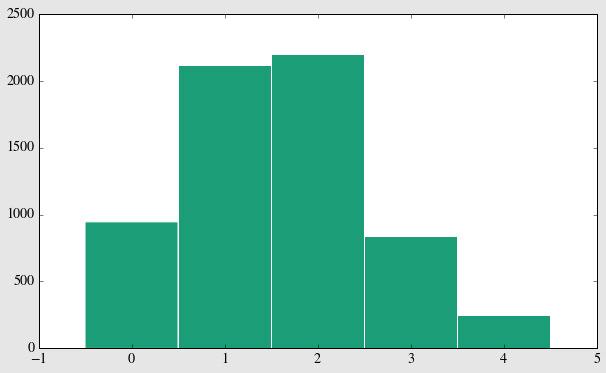

In [12]:
freq, b, _ = plt.hist(full_df.stars,bins=np.linspace(-0.5, 4.5, 6))

In [13]:
freq

array([  945.,  2114.,  2199.,   838.,   246.])

In [14]:
star_priors = (freq / len(full_df))

In [15]:
len(users_df), len(questions_df), len(answers_df)

(4727, 1321, 6342)

In [16]:
# generate the train/test split index arrays
# (split the entire (user,question) set, then split full_df accordingly)
n_folds = 5
folds = KFold(len(users_df)*len(questions_df), n_folds = n_folds, shuffle = True)

In [17]:
import itertools as it

In [18]:
uq = pd.Series(list(it.product(users_df.index, questions_df.index)))

In [19]:
train_dfs = []
test_dfs = []

full_df = full_df.set_index(full_df.id_pair)

for train, test in folds:   

    trdf = full_df.ix[uq.ix[train]].dropna()
    tsdf = full_df.ix[uq.ix[test]].dropna()
    train_dfs.append(trdf)
    test_dfs.append(tsdf)

In [20]:
for train, test in folds:
    print len(train), len(test)

4995493 1248874
4995493 1248874
4995494 1248873
4995494 1248873
4995494 1248873


In [21]:
for i in range(n_folds):
    print len(train_dfs[i]), len(test_dfs[i])

5083 1259
5053 1289
5158 1184
5022 1320
5052 1290


In [22]:
full_df.head()

id_pair                                           question  \
id_pair                                                               
(15, 1)  (15, 1)  How to survive mountain environments with a tr...   
(16, 3)  (16, 3)  What is the minimum human population necessary...   
(15, 3)  (15, 3)  What is the minimum human population necessary...   
(15, 8)  (15, 8)  Must magic be tied to medieval tech? Most sett...   
(19, 8)  (19, 8)  Must magic be tied to medieval tech? Most sett...   

        question_id  score                               tags user_id  stars  
id_pair                                                                       
(15, 1)           1      9  [environment, altitude, mountain]      15      3  
(16, 3)           3     21          [society, colony, humans]      16      4  
(15, 3)           3      8          [society, colony, humans]      15      3  
(15, 8)           8      1                [technology, magic]      15      1  
(19, 8)           8      3                [technology, magic]      19      2

In [23]:
for i in xrange(n_folds):
    test_dfs[i]['feature_vec'] = test_dfs[i].question.apply(rc.post2LDAvec).apply(rc.LDAvec2ndarray)

In [24]:
test_dfs[3].head()

id_pair                                           question  \
(6, 8)        (6, 8)  Must magic be tied to medieval tech? Most sett...   
(6, 325)    (6, 325)  Ensuring consistency in a world I want to be a...   
(6, 1412)  (6, 1412)  Massive Maelstroms Maelstroms are ginormous wh...   
(7, 2)        (7, 2)  How can I break down the task of creating a wo...   
(7, 39)      (7, 39)  How would priests having access to real miracl...   

          question_id  score  \
(6, 8)              8     16   
(6, 325)          325      3   
(6, 1412)        1412      1   
(7, 2)              2     18   
(7, 39)            39      3   

                                                        tags user_id  stars  \
(6, 8)                                   [technology, magic]       6      3   
(6, 325)                          [science-based, verifying]       6      2   
(6, 1412)  [science-based, environment, earth-like, clima...       6      1   
(7, 2)                               [worldbuilding-process]       7      4   
(7, 39)                                           [religion]       7      2   

                                                 feature_vec  
(6, 8)     [0.0, 0.144655297156, 0.0, 0.0, 0.0, 0.0, 0.24...  
(6, 325)   [0.0, 0.0, 0.0122502188386, 0.0, 0.01352883224...  
(6, 1412)  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0484634688872...  
(7, 2)     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
(7, 39)    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

# disconnected LDA models 

In [76]:
class ZeroClassifier(object):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return
    
    def predict(self, X):
        return 0.
    
    def predict_proba(self, X):
        return np.array([[1.,0.]])

In [77]:
class SingleClassifier(object):
    
    def __init__(self):
        self.single_class = None
        return
    
    def __str__(self):
        return "SingleClassifier(class="+str(self.single_class)+")"
    
    def fit(self, X, y):
        self.single_class = y[0]
        return
    
    def predict(self, X):
        return np.array([self.single_class])
    
    def predict_proba(self, X):
        return np.array([1.])

In [78]:
class DotClassifier(object):
    
    def __init__(self, threshold = 0.5, k = 1.):
        self.vec = 0.
        self.threshold = threshold
        self.k = k
        return 
    
    def __str__(self):
        return "DotClassifier(threshold="+str(self.threshold)+", k="+str(self.k)+")"
    
    def sigmoid(self, a):
        return (1. / (1. + np.exp( -self.k*a )))
    
    def fit(self, X, y):
        self.vec = np.sum(X, axis=0)
        return
    
    def predict(self, X):
        x = X
        return self.sigmoid(np.dot(self.vec,x)) > self.threshold
    
    def predict_proba(self, X):
        x = X
        a = self.sigmoid(np.dot(self.vec,x))
        return np.array([[1-a, a]])

In [79]:
star_priors

array([ 0.1568323 ,  0.39440994,  0.36801242,  0.07453416,  0.00621118])

In [80]:
def xlen(a):
    if a[0] is not None:
        return len(a)
    else:
        return 0

In [81]:
def gen_priors(starlist):
    starlist = [int(star) for star in starlist]
    return star_priors[(np.array(starlist))]/sum(star_priors[(np.array(starlist))])

### Scoring Starts Here

In [82]:
# parameters for the run
num_topics = 100
iterations = 1000
passes = 1
tfidf = False
#model_clf = LogisticRegression(fit_intercept = False, penalty = 'l2')
star_weight = 1.
# model_clf = RandomForestClassifier() 
# model_clf = DotClassifier(threshold = threshold, k=1000)
model_clf = MultinomialNB()
# model_clf = SVC()

In [83]:
results = [0] * n_folds
n_folds_to_train = 5
verbose = False

# train the LDA model on the fold?
train_LDA = False

# set the number of workers
multiprocessing = False
n_procs = 7

def printv(a):
    if verbose:
        print a
        sys.stdout.flush()
    return

def make_poolmap(multiprocessing=True, n_procs=7):
    if multiprocessing:
        pool = pmp.Pool(n_procs)
        return pool.map
    else:
        return map

start_time = time.time()
for i in range(n_folds_to_train):
    
    printv("\nFold %d/%d" % (i+1, n_folds))
    
    fold_start_time = time.time()
    if train_LDA: 
        rc = Recommender(site_name, df_dict = train_df_dicts[i])
    rc.train(num_topics = num_topics, iterations = iterations, 
             passes = passes, multicore = True, tfidf = tfidf,
             train_LDA = train_LDA)

    #reset the classifiers and setup new user groups
    users_df['clf'] = None
    users_df['X'] = None
    users_df['y'] = None
    user_gps = train_dfs[i].groupby('user_id')
    
    # do logistic regression for each user
    printv("Fitting...")
    
    printv(" ...creating training vectors.")
    
    def make_X(user):
        LDAvec = rc.post2LDAvec(user_gps.get_group(user).question)
        vec = rc.LDAvec2ndarray(LDAvec)
        stars = user_gps.get_group(user).stars[:,np.newaxis]
        #X = np.vstack([np.zeros(rc.LDAmodel.num_topics),
        #              vec*(star_weight*stars)])
        X = vec
        return X

    def make_y(user):
        # y = np.concatenate([[1],(user_gps.get_group(user).stars).values])
        y = user_gps.get_group(user).stars.values
        return y

    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    users_df['X'].ix[user_gps.groups.keys()] = my_map(make_X, user_gps.groups.keys())     
    
    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    users_df['y'].ix[user_gps.groups.keys()] = my_map(make_y, user_gps.groups.keys())
    
    priors = users_df.y.ix[user_gps.groups.keys()].map(np.unique).map(gen_priors)
    users_df.clf.ix[user_gps.groups.keys()] = [MultinomialNB(class_prior = pl) for pl in priors]
    #users_df.clf.ix[user_gps.groups.keys()] = [model_clf for _ in xrange(len(user_gps.groups.keys()))]
    
    # classifiers don't like to train on a single example
    users_df.clf[users_df.y.map(np.unique).map(xlen) == 1] = SingleClassifier()
    users_df.clf[users_df.y.map(np.unique).map(xlen) == 0] = None
    
    printv(" ...done creating training vectors.")
    printv(" ...fitting the classifiers.")
    
    #my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def fita(user_id):
        users_df.clf.ix[user_id].fit(users_df.X.ix[user_id],users_df.y.ix[user_id])
        return
    map(fita, user_gps.groups.keys())
    
    printv(" ...done fitting.")
    printv("Testing...")

    # compute the results of the fold
    results[i] = pd.DataFrame()
    results[i]['actual'] = test_dfs[i].stars.values
    results[i]['user_id'] = test_dfs[i].user_id.values
    results[i]['question_id'] = test_dfs[i].question_id.values
    results[i]['predicted'] = 0.
    results[i]['proba'] = 0.
    printv(" ... recording results.")

    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def predictproba(a):
        if a[0] is not None:
            return a[0].predict_proba(a[1])[0]
        else:
            return None
    #results[i]['proba'] = my_map(predictproba, 
    #                            zip(users_df.clf.ix[test_dfs[i].user_id], 
    #                            test_dfs[i].feature_vec))
    #printv(" ... got the probabilities.")
    
    my_map = make_poolmap(multiprocessing=multiprocessing, n_procs=n_procs)
    def predicta(a):
        if a[0] is not None:
            return a[0].predict(a[1])[0]
        else:
            return None
    results[i]['predicted'] = my_map(predicta, zip(users_df.clf.ix[test_dfs[i].user_id], 
                                test_dfs[i].feature_vec))
    
    fold_end_time = time.time()
    printv("Fold done: %s" % str(datetime.timedelta(seconds=(fold_end_time-fold_start_time))))
    sys.stdout.flush()

full_results = pd.DataFrame(data={'actual':np.concatenate([x.actual for x in results[:n_folds_to_train]]), 
                                  'predicted':np.concatenate([x.predicted for x in results[:n_folds_to_train]])})#,
                                  #'proba':np.concatenate([x.proba for x in results[:n_folds_to_train]])})

print "\nnumber of folds trained %d/%d" % (n_folds_to_train, n_folds)
print "num_topics =", num_topics
print model_clf
print "RMSE: %.5f" % (np.sqrt(sklearn.metrics.mean_squared_error(full_results.dropna().actual, 
                                                                 full_results.dropna().predicted)))
end_time = time.time()
print "Time: ", str(datetime.timedelta(seconds=(end_time-start_time)))

Training...
Done training!
Training...
Done training!
Training...
Done training!
Training...
Done training!
Training...
Done training!

number of folds trained 5/5
num_topics = 100
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
RMSE: 0.96700
Time:  0:00:20.308070


# kNN similarity model 

In [27]:
train_adfs = []
test_adfs = []


for i in range(n_folds):
    
    answers_df['id_pair'] = zip(answers_df.user_id, answers_df.parent_id)
    a_train = answers_df.copy()
    a_test = answers_df.copy()
    train_pairs = set(train_dfs[i].index)
    test_pairs = set(test_dfs[i].index)
    a_train = a_train[a_train.id_pair.isin(train_pairs)]
    a_test = a_test[a_test.id_pair.isin(test_pairs)]
    
    train_adfs.append(a_train)
    test_adfs.append(a_test)

In [28]:
for i in range(n_folds):
    print len(train_adfs[i]), len(test_adfs[i])

5083 1259
5053 1289
5158 1184
5022 1320
5052 1290


In [29]:
rc_dfs = site.df_dict()
results = [0] * n_folds
n_folds_to_train = 5

start_time = time.time()

for i in xrange(n_folds_to_train):
    
    rc_dfs['answers'] = train_adfs[i]
    rc.train(df_dict=rc_dfs,train_LDA=False)
    
    results[i] = pd.DataFrame()
    results[i]['actual'] = test_dfs[i].stars.values
    results[i]['user_id'] = test_dfs[i].user_id.values
    results[i]['question_id'] = test_dfs[i].question_id.values
    results[i]['proba'] = 1.    
    results[i]['predicted'] = None
    
    for j in trange(len(test_dfs[i]), leave=False):
        user = test_dfs[i].user_id.irow(j)
        qidx = rc.question_idx[test_dfs[i].question_id.irow(j)]
        results[i]['predicted'][j] = rc.predict_stars(user, qidx)[0]

full_results = pd.DataFrame(data={'actual':np.concatenate([x.actual for x in results[:n_folds_to_train]]), 
                                  'predicted':np.concatenate([x.predicted for x in results[:n_folds_to_train]])})

end_time=time.time()

print "\n\nRMSE: %.5f" % (np.sqrt(sklearn.metrics.mean_squared_error(full_results.dropna().actual, 
                                                                 full_results.dropna().predicted)))
print "Time: ", str(datetime.timedelta(seconds=(end_time-start_time)))

                                                                         

RMSE: 1.30892
Time:  0:14:36.720649


# worldbuiding: Results

    Trivial Model
    number of folds trained 5/5
    num_topics = 100
    RMSE: 1.12796

    number of folds trained 5/5
    num_topics = 100
    MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    RMSE: 0.96700
    Time:  0:00:20.308070
    
    number of folds trained 5/5
    num_topics = 100
    RandomForestClassifier(bootstrap=True, compute_importances=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
                min_samples_split=2, n_estimators=10, n_jobs=1,
                oob_score=False, random_state=None, verbose=0)
    RMSE: 1.84997
    Time:  0:03:31.241016
    
    number of folds trained 5/5
    num_topics = 100
    SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
      kernel='rbf', max_iter=-1, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False)
    RMSE: 1.85362
    Time:  0:03:05.993202
    
    collaborative model
    RMSE: 1.30892
    Time:  0:14:36.720649

# trivial model 

The "trivial" model simply predicts that any (and every) user will get the average number of stars on each question (independent of user).

In [29]:
model_qdf = [0] * n_folds

In [26]:
q_gps = train_dfs[0].groupby('question_id')
model_qdf[0] = pd.DataFrame(q_gps.stars.mean(), index=q_gps.groups.keys())

In [27]:
model_qdf[0].head()

stars
6961   1.333333
9075   1.166667
3925   1.333333
10295  2.200000
3928   1.818182

In [31]:
n_folds_to_train = 5
results = [0] * n_folds
model_qdf = [0] * n_folds

for i in range(n_folds):
    
    # make the trivial model
    q_gps = train_dfs[i].groupby('question_id')
    model_qdf = pd.DataFrame(q_gps.stars.mean(), index=q_gps.groups.keys())
    
    def trivial_model(question_id):
        if question_id in model_qdf.index:
            return model_qdf.stars.ix[question_id]
        else:
            return None
    
    results[i] = pd.DataFrame()
    results[i]['actual'] = test_dfs[i].stars.values
    results[i]['user_id'] = test_dfs[i].user_id.values
    results[i]['question_id'] = test_dfs[i].question_id.values
    results[i]['predicted'] = map(trivial_model, test_dfs[i].question_id)
    results[i]['proba'] = 1.

full_results = pd.DataFrame(data={'actual':np.concatenate([x.actual for x in results[:n_folds_to_train]]), 
                                  'predicted':np.concatenate([x.predicted for x in results[:n_folds_to_train]]),
                                  'proba':np.concatenate([x.proba for x in results[:n_folds_to_train]])})

In [34]:
print "Trivial Model"
print "number of folds trained %d/%d" % (n_folds_to_train, n_folds)
print "RMSE: %.5f" % (np.sqrt(sklearn.metrics.mean_squared_error(full_results.dropna().actual, 
                                                                 full_results.dropna().predicted)))

Trivial Model
number of folds trained 5/5
RMSE: 1.13036


In [35]:
r = full_results.dropna().actual.values
rhat = full_results.dropna().predicted.values

In [39]:
np.sqrt(((r-rhat)**2).sum() / len(r))

1.1303555914656112